## CSVデータを読み込んで、グラフに表示する

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('log000.csv')
df.head()

Temperature  Humidity   Time
0         27.4      37.1  10129
1         27.5      35.8  20250
2         27.4      35.8  30368
3         27.4      35.9  40486
4         27.2      35.9  50604

In [3]:
df = df.set_index('Time')
df.head()

Temperature  Humidity
Time                        
10129         27.4      37.1
20250         27.5      35.8
30368         27.4      35.8
40486         27.4      35.9
50604         27.2      35.9

In [4]:
df.plot();

## 熱中症指標を使って、気温と湿度に対する熱中症危険度を計算する

heatstroke_score : 気温と湿度から、熱中症で搬送される人数を予測する指標

In [5]:
# 熱中症指標
import math

temperature_weight_a = 0.00064266
temperature_weight_b = 0.41153465
humidity_weight = -0.02849993

def heatstroke_score(temp, hum):
    score = temperature_weight_a * math.exp(temperature_weight_b * temp) + humidity_weight * hum
    scale_modified_score = score
    return scale_modified_score

In [6]:
# 計測した気温と湿度に対する熱中症指標を計算
df['score'] = df.apply(lambda row: heatstroke_score(row.Temperature, row.Humidity), axis=1)
df.head()

Temperature  Humidity      score
Time                                   
10129         27.4      37.1  49.654252
20250         27.5      35.8  51.821798
30368         27.4      35.8  49.691302
40486         27.4      35.9  49.688452
50604         27.2      35.9  45.681689

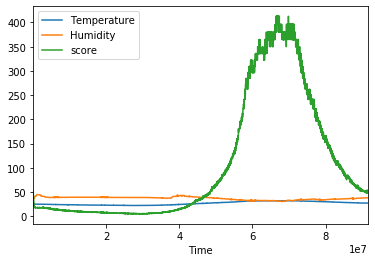

In [7]:
df.plot();

## 熱中症教師データの作成

熱中症スコア(搬送される人数)が200以上の場合に、熱中症の危険度大と仮定する

In [8]:
df['heatstroke'] = df['score'].apply(lambda score: 1 if score > 200 else 0)
df.head()

Temperature  Humidity      score  heatstroke
Time                                               
10129         27.4      37.1  49.654252           0
20250         27.5      35.8  51.821798           0
30368         27.4      35.8  49.691302           0
40486         27.4      35.9  49.688452           0
50604         27.2      35.9  45.681689           0

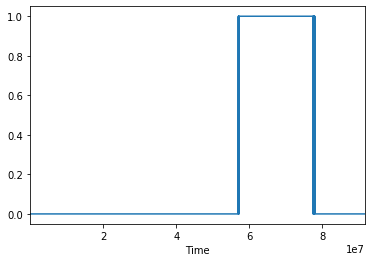

In [9]:
df['heatstroke'].plot();

In [10]:
df.to_csv("heatstroke.csv")

## 熱中症データの学習・予測

温度・湿度を説明変数、scoreを目的変数として、facebook prophetを用いて学習する

In [11]:
from fbprophet import Prophet

In [22]:
import datetime

# データ取得日時
data_time = datetime.datetime(2019, 6, 20, 18, 4)

In [25]:
train = df[["Temperature", "Humidity"]]
train["y"] = df["score"]
train = train.reset_index()
train["ds"] = train["Time"]
train = train.drop("Time", axis=1)
train["ds"] = train["ds"].apply(lambda ms: data_time + datetime.timedelta(milliseconds=ms))
train.head()

C:\ProgramData\Anaconda3\envs\ai-sensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Temperature  Humidity          y                      ds
0         27.4      37.1  49.654252 2019-06-20 18:04:10.129
1         27.5      35.8  51.821798 2019-06-20 18:04:20.250
2         27.4      35.8  49.691302 2019-06-20 18:04:30.368
3         27.4      35.9  49.688452 2019-06-20 18:04:40.486
4         27.2      35.9  45.681689 2019-06-20 18:04:50.604

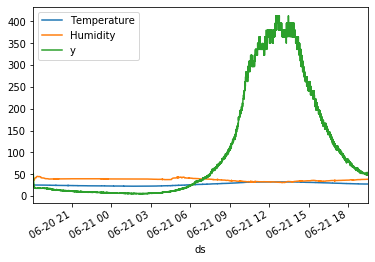

In [48]:
train.set_index("ds").plot();

In [26]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


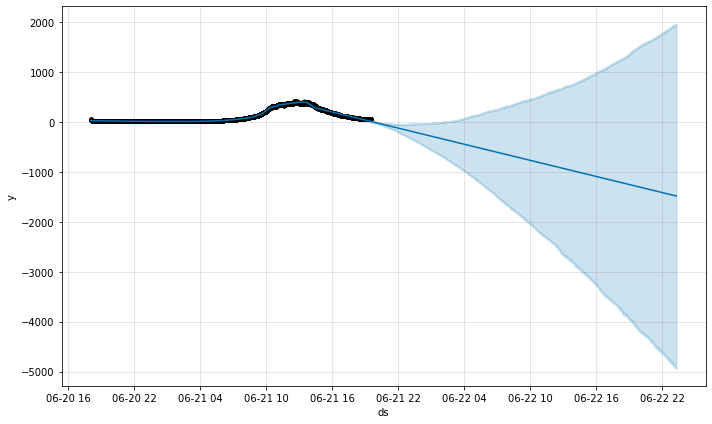

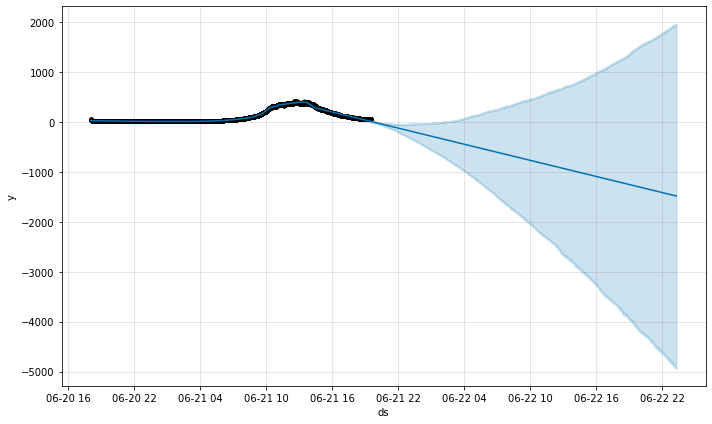

In [49]:
# 予想する
future = m.make_future_dataframe(periods=100000, freq='S')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

m.plot(forecast)